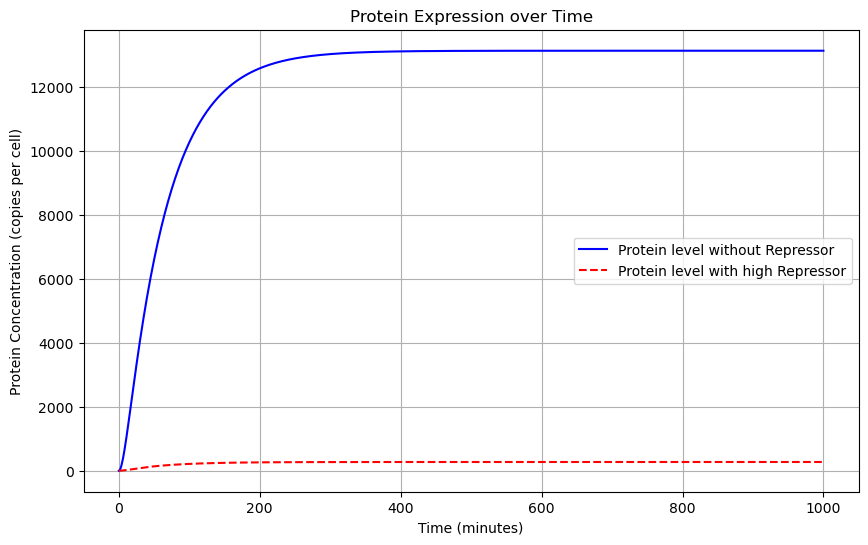

In [1]:
# Task 1

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Part 1: Figure of presence/absence of repressor

# Define model parameters
km0 = 0.01  # Basal transcription rate
km = 5  # Maximum transcription rate
K = 500  # Repressor dissociation constant
n = 2  # Hill coefficient
kdm = 0.1386  # mRNA degradation rate
kp = 1.2  # Translation rate
kdp = 0.0165  # Protein degradation rate

# Model equations
def model(y, t, Pr):
    M, P = y
    rate_M_prod = km0 + (km * K / (Pr + K))**n
    rate_M_loss = kdm * M
    rate_P_prod = kp * M
    rate_P_loss = kdp * P
    dM = rate_M_prod - rate_M_loss
    dP = rate_P_prod - rate_P_loss
    return [dM, dP]

# Initial conditions
M0 = 0  # initial mRNA level
P0 = 0  # initial protein level
y0 = [M0, P0]

# Time points
t = np.linspace(0, 1000, 1000)  # 1000 minutes

# Run simulations
Pr0 = 0  # Repressor absent
sol0 = odeint(model, y0, t, args=(Pr0,))

Pr3000 = 3000  # Repressor at high levels
sol3000 = odeint(model, y0, t, args=(Pr3000,))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t, sol0[:, 1], label='Protein level without Repressor', linestyle='-', color='blue')
plt.plot(t, sol3000[:, 1], label='Protein level with high Repressor', linestyle='--', color='red')
plt.title('Protein Expression over Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Protein Concentration (copies per cell)')
plt.legend()
plt.grid(True)
plt.savefig('Protein_expression_over_time.png')


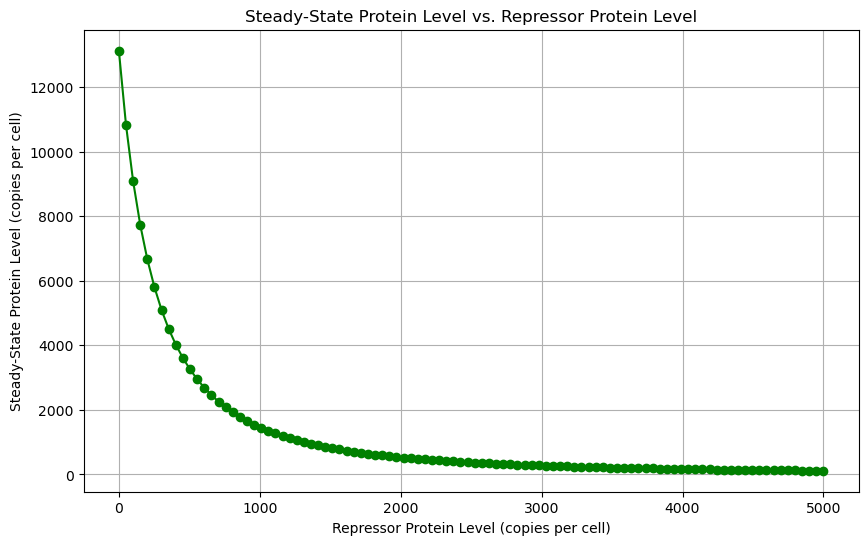

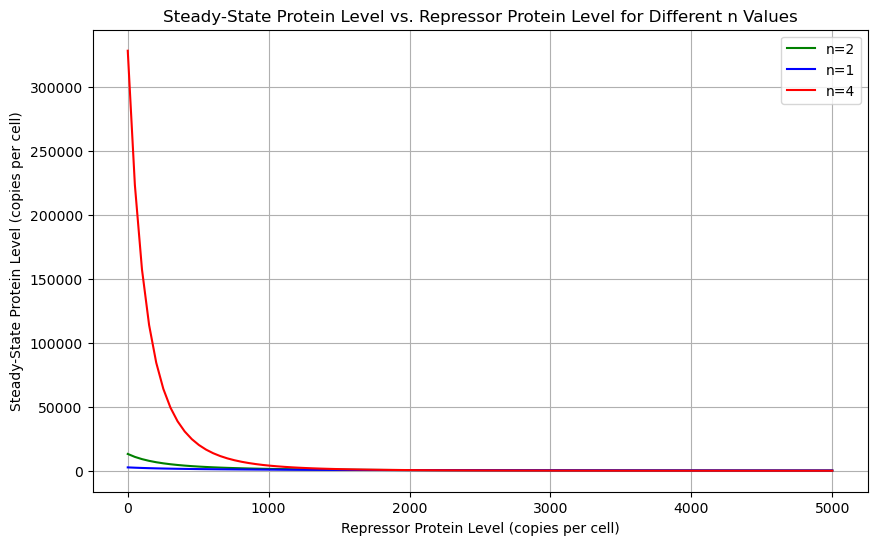

In [2]:
# Part 2: Plot summarising the relationship between expressed steady state protein level, vs level of repressor protein
# And plot with overlays showing the results for n=1, 2 and 4

# Range of repressor protein levels
Pr_values = np.linspace(0, 5000, 100)
steady_state_protein_levels = []

# Simulate for each Pr value and extract the steady-state protein level
for Pr in Pr_values:
    sol = odeint(model, y0, t, args=(Pr,))
    steady_state_protein_levels.append(sol[-1, 1])  # Steady state value

# Plot the relationship
plt.figure(figsize=(10, 6))
plt.plot(Pr_values, steady_state_protein_levels, linestyle='-', marker='o', color='green')
plt.title('Steady-State Protein Level vs. Repressor Protein Level')
plt.xlabel('Repressor Protein Level (copies per cell)')
plt.ylabel('Steady-State Protein Level (copies per cell)')
plt.grid(True)
plt.savefig('Steady-state_protein_vs_repressor.png')
plt.show()

# Update model function to accept n as a parameter
def model_n(y, t, Pr, n):
    M, P = y
    rate_M_prod = km0 + (km * K / (Pr + K))**n
    rate_M_loss = kdm * M
    rate_P_prod = kp * M
    rate_P_loss = kdp * P
    dM = rate_M_prod - rate_M_loss
    dP = rate_P_prod - rate_P_loss
    return [dM, dP]

# Initialize lists to store steady-state protein levels for different n values
P_ss_vals_n1 = []
P_ss_vals_n4 = []

# Simulation parameters
n_values = [1, 4]  # Additional n values
Pr_values = np.linspace(0, 5000, 100)  # Repressor protein levels

# Perform simulations for n = 1
for Pr in Pr_values:
    sol_n1 = odeint(model_n, y0, t, args=(Pr, 1))
    P_ss_vals_n1.append(sol_n1[-1, 1])

# Perform simulations for n = 4
for Pr in Pr_values:
    sol_n4 = odeint(model_n, y0, t, args=(Pr, 4))
    P_ss_vals_n4.append(sol_n4[-1, 1])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(Pr_values, steady_state_protein_levels, label='n=2', linestyle='-', marker='', color='green')
plt.plot(Pr_values, P_ss_vals_n1, label='n=1', linestyle='-', marker='', color='blue')
plt.plot(Pr_values, P_ss_vals_n4, label='n=4', linestyle='-', marker='', color='red')
plt.title('Steady-State Protein Level vs. Repressor Protein Level for Different n Values')
plt.xlabel('Repressor Protein Level (copies per cell)')
plt.ylabel('Steady-State Protein Level (copies per cell)')
plt.legend()
plt.grid(True)

plt.savefig('Steady-state_protein_vs_repressor_n_vals.png')

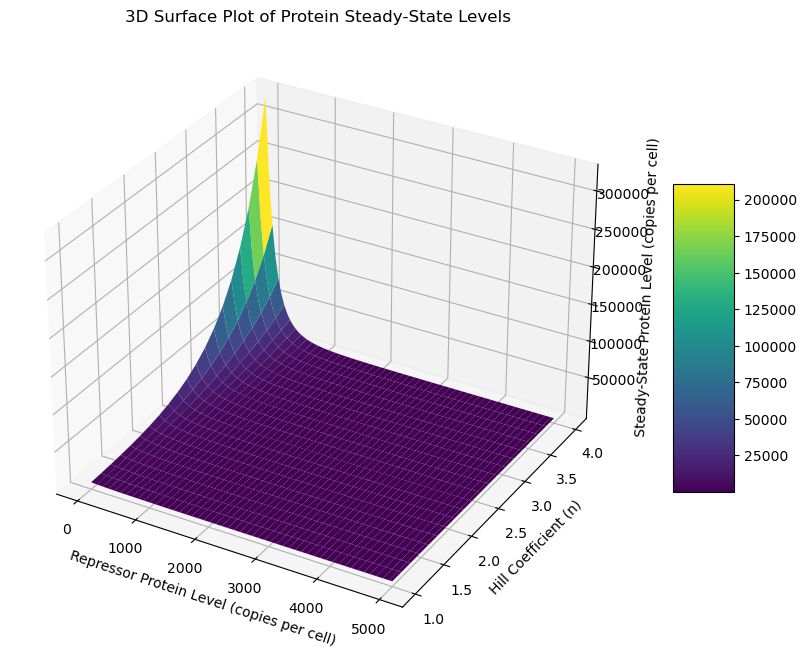

In [3]:
# Part 3: Figure showing protein steady state levels under different repressor levels and co-operativity

from mpl_toolkits.mplot3d import Axes3D

# Define a range of n values for cooperativity
n_values_range = np.linspace(1, 4, 20)

# Create a grid for Pr and n values
Pr_grid, n_grid = np.meshgrid(Pr_values, n_values_range)

# Initialize an array to store the steady-state protein levels for each (Pr, n) pair
P_ss_grid = np.zeros_like(Pr_grid)

# Perform simulations for each (Pr, n) pair
for i in range(Pr_grid.shape[0]):
    for j in range(Pr_grid.shape[1]):
        Pr = Pr_grid[i, j]
        n = n_grid[i, j]
        sol = odeint(model_n, y0, t, args=(Pr, n))
        P_ss_grid[i, j] = sol[-1, 1]  # Steady-state protein level


# Creating a 3D surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(Pr_grid, n_grid, P_ss_grid, cmap='viridis', edgecolor='none')

# Labels and title
ax.set_title('3D Surface Plot of Protein Steady-State Levels')
ax.set_xlabel('Repressor Protein Level (copies per cell)')
ax.set_ylabel('Hill Coefficient (n)')
ax.set_zlabel('Steady-State Protein Level (copies per cell)')

# Colorbar
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig('3D_surface_plot.png')


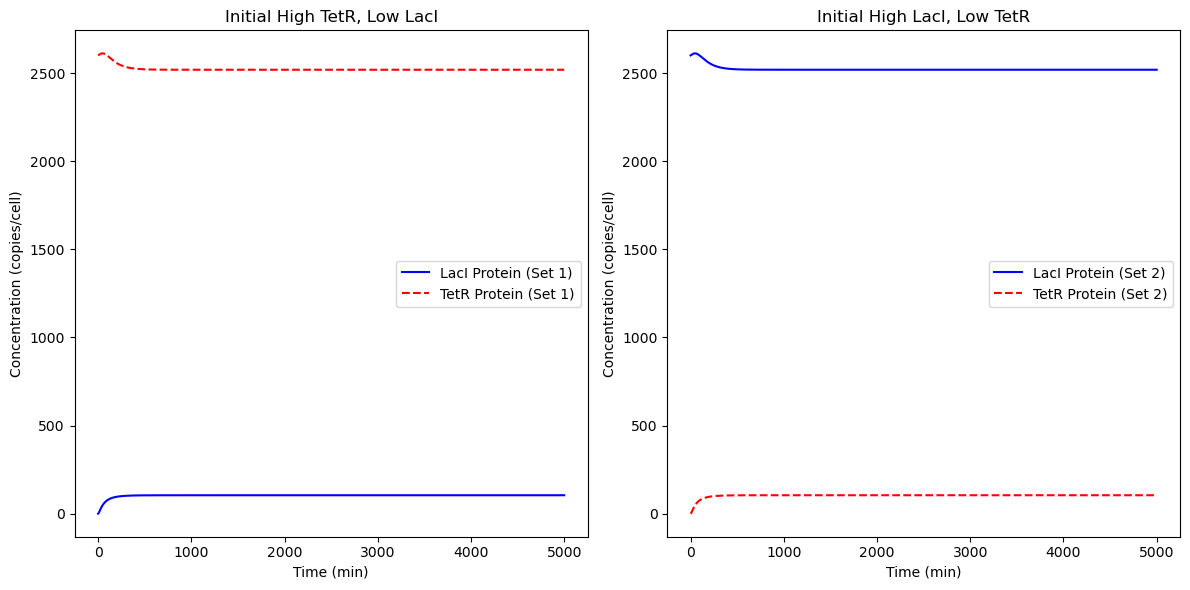

In [4]:
# Task 2

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import cm

# Part 1: ODE simulation of the system to demonstrate that it is bistable (ends in two steady states)

# Define the model
def toggle_switch(y, t, params):
    ML, PL, MT, PT = y
    km0L, kmL, KR, nR, kdmL, kpL, kdpL, km0T, kmT, KL, nL, kdmT, kpT, kdpT = params
    
    # LacI mRNA (ML) rate of change
    dMLdt = km0L + kmL / (1 + (PT/KR)**nR) - kdmL * ML
    
    # LacI protein (PL) rate of change
    dPLdt = kpL * ML - kdpL * PL
    
    # TetR mRNA (MT) rate of change
    dMTdt = km0T + kmT / (1 + (PL/KL)**nL) - kdmT * MT
    
    # TetR protein (PT) rate of change
    dPTdt = kpT * MT - kdpT * PT
    
    return [dMLdt, dPLdt, dMTdt, dPTdt]

# Parameters
km0L = km0T = 0.01
kmL = kmT = 5
KR = KL = 500
nR = nL = 2
kdmL = kdmT = 0.1386
kpL = kpT = 1.2
kdpL = kdpT = 0.0165
params = [km0L, kmL, KR, nR, kdmL, kpL, kdpL, km0T, kmT, KL, nL, kdmT, kpT, kdpT]

# Time vector
t = np.linspace(0, 5000, 1000)  # Simulate for 5000 minutes

# Initial conditions
initial_conditions_set1 = [0, 0, 36, 2600]  # High TetR, Low LacI
initial_conditions_set2 = [36, 2600, 0, 0]  # High LacI, Low TetR

# Integrate the ODEs for both sets of initial conditions
solution_set1 = odeint(toggle_switch, initial_conditions_set1, t, args=(params,))
solution_set2 = odeint(toggle_switch, initial_conditions_set2, t, args=(params,))

# Part 2: Figure of bistability of the toggle switch system.

# Plotting the results to visualize bistability
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(t, solution_set1[:, 1], 'b-', label='LacI Protein (Set 1)')
plt.plot(t, solution_set1[:, 3], 'r--', label='TetR Protein (Set 1)')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (copies/cell)')
plt.title('Initial High TetR, Low LacI')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, solution_set2[:, 1], 'b-', label='LacI Protein (Set 2)')
plt.plot(t, solution_set2[:, 3], 'r--', label='TetR Protein (Set 2)')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (copies/cell)')
plt.title('Initial High LacI, Low TetR')
plt.legend()

plt.tight_layout()
plt.savefig('bistability plot.png')


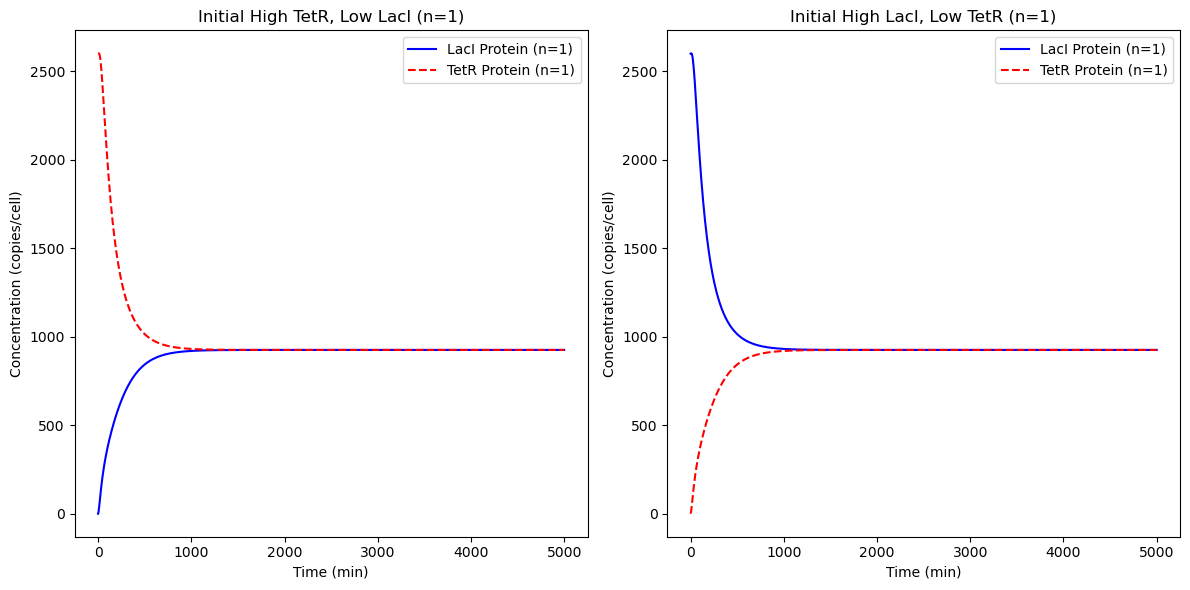

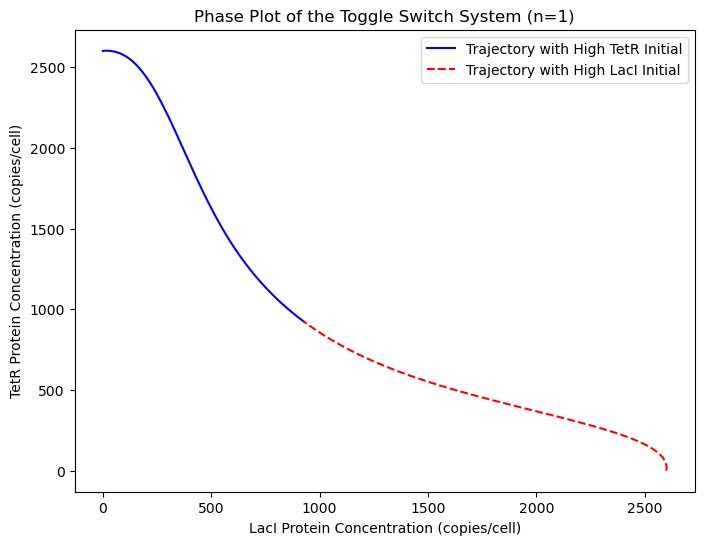

In [5]:
# Part 3: Figure displaying the behaviour of the toggle switch system when n=1

# Updating the n values to 1 for both repressors
nR = nL = 1
params_n1 = [km0L, kmL, KR, nR, kdmL, kpL, kdpL, km0T, kmT, KL, nL, kdmT, kpT, kdpT]

# Integrating the ODEs for both sets of initial conditions with updated n values
solution_set1_n1 = odeint(toggle_switch, initial_conditions_set1, t, args=(params_n1,))
solution_set2_n1 = odeint(toggle_switch, initial_conditions_set2, t, args=(params_n1,))

# Plotting the results to visualize the lack of bistability with n=1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(t, solution_set1_n1[:, 1], 'b-', label='LacI Protein (n=1)')
plt.plot(t, solution_set1_n1[:, 3], 'r--', label='TetR Protein (n=1)')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (copies/cell)')
plt.title('Initial High TetR, Low LacI (n=1)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, solution_set2_n1[:, 1], 'b-', label='LacI Protein (n=1)')
plt.plot(t, solution_set2_n1[:, 3], 'r--', label='TetR Protein (n=1)')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (copies/cell)')
plt.title('Initial High LacI, Low TetR (n=1)')
plt.legend()

plt.tight_layout()
plt.savefig('Toggle_switch_behaviour_n=1.png')

# Optional additional plot: phase plot showing the behavior of the toggle switch system when the cooperativity parameter (n) is set to 1
# The trajectories of the system starting with high TetR (blue solid line) and high LacI (red dashed line) eventually converge, 
# indicating that regardless of the starting conditions, the system settles at a similar state where both TetR and LacI 
# protein levels balance each other out.

# Generating a phase plot for the two proteins
plt.figure(figsize=(8, 6))
plt.plot(solution_set1_n1[:, 1], solution_set1_n1[:, 3], 'b-', label='Trajectory with High TetR Initial')
plt.plot(solution_set2_n1[:, 1], solution_set2_n1[:, 3], 'r--', label='Trajectory with High LacI Initial')
plt.xlabel('LacI Protein Concentration (copies/cell)')
plt.ylabel('TetR Protein Concentration (copies/cell)')
plt.title('Phase Plot of the Toggle Switch System (n=1)')
plt.legend()
plt.savefig('Phase_plot_n=1.png')


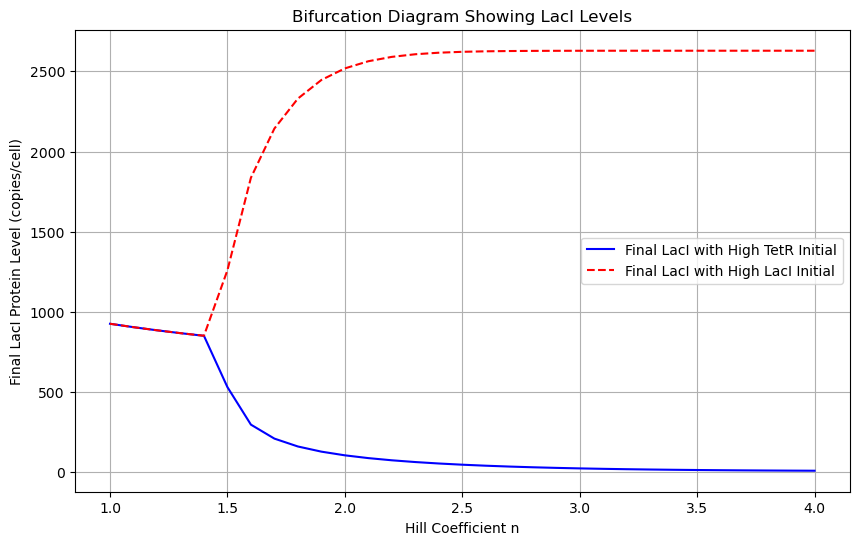

In [6]:
# Part 4: Bifurcation plot exploring the minimum value of n required for the model to exhibit bistability.

# Defining the range of n values to explore for bistability
n_vals = np.arange(1, 4.1, 0.1)
# Arrays to store the final LacI levels for both initial conditions
PL_final_1 = np.zeros(len(n_vals))
PL_final_2 = np.zeros(len(n_vals))

# Time vector for longer simulation
t_long = np.linspace(0, 10000, 2000)  # Simulate for 10000 minutes

# Running simulations over the range of n values
for i, n in enumerate(n_vals):
    # Update parameters with the current n value
    params_n = [km0L, kmL, KR, n, kdmL, kpL, kdpL, km0T, kmT, KL, n, kdmT, kpT, kdpT]
    
    # Integrating the ODEs for the TetR high initial condition
    solution_high_TetR = odeint(toggle_switch, initial_conditions_set1, t_long, args=(params_n,))
    PL_final_1[i] = solution_high_TetR[-1, 1]  # Record the final LacI protein level
    
    # Integrating the ODEs for the LacI high initial condition
    solution_high_LacI = odeint(toggle_switch, initial_conditions_set2, t_long, args=(params_n,))
    PL_final_2[i] = solution_high_LacI[-1, 1]  # Record the final LacI protein level

# Plotting the bifurcation diagram using the final LacI protein levels for each n value
plt.figure(figsize=(10, 6))
plt.plot(n_vals, PL_final_1, 'b-', label='Final LacI with High TetR Initial')
plt.plot(n_vals, PL_final_2, 'r--', label='Final LacI with High LacI Initial')
plt.xlabel('Hill Coefficient n')
plt.ylabel('Final LacI Protein Level (copies/cell)')
plt.title('Bifurcation Diagram Showing LacI Levels')
plt.legend()
plt.grid(True)
plt.savefig('Bifurcation_diagram_of_LacI_levels.png')
            

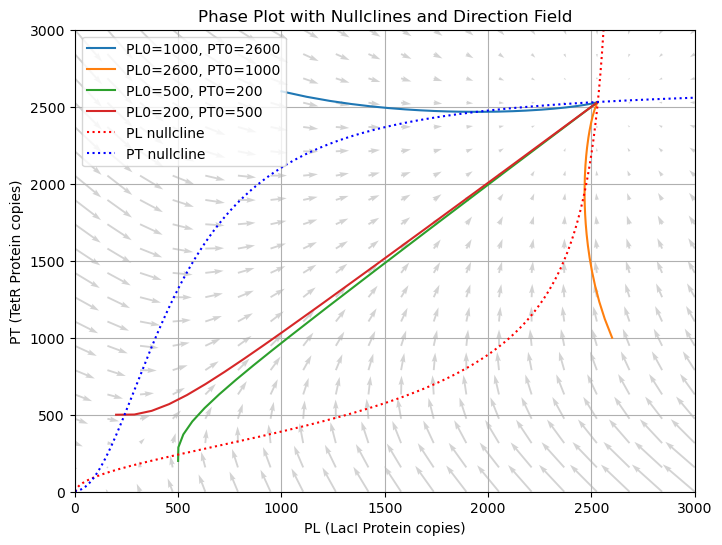

In [7]:
# Part 5: Phase Plot showing Toggle Switch system behaviour with n=2

# System parameters (given)
v_poL = v_poT = 0.0866
v_pL = v_pT = 43.3
v_dpL = v_dpT = 0.0165
K_L = K_T = 500
n_L = n_T = 2

# Defining the reduced model
def reduced_toggle_switch(y, t):
    PL, PT = y
    dPL_dt = v_poL + (v_pL * PT**n_T) / (K_T**n_T + PT**n_T) - v_dpL * PL
    dPT_dt = v_poT + (v_pT * PL**n_L) / (K_L**n_L + PL**n_L) - v_dpT * PT
    return [dPL_dt, dPT_dt]

# Initial conditions
initial_conditions = [
    (2600, 1000),  # PT high, PL medium
    (1000, 2600),  # PT medium, PL high
    (200, 500),    # PT low, PL medium-low
    (500, 200)     # PT medium-low, PL low
]

# Time vector
t = np.linspace(0, 5000, 1000)  # Simulate for 5000 minutes

# Generate phase plot with trajectories for the different initial conditions
plt.figure(figsize=(8, 6))
for PT0, PL0 in initial_conditions:
    trajectory = odeint(reduced_toggle_switch, [PL0, PT0], t)
    plt.plot(trajectory[:, 0], trajectory[:, 1], label=f'PL0={PL0}, PT0={PT0}')

# Direction field / Vector field
PL_vals = np.linspace(0, 3000, 20)
PT_vals = np.linspace(0, 3000, 20)
PL_mesh, PT_mesh = np.meshgrid(PL_vals, PT_vals)
dPL_mesh, dPT_mesh = reduced_toggle_switch([PL_mesh, PT_mesh], t)
plt.quiver(PL_mesh, PT_mesh, dPL_mesh, dPT_mesh, color='lightgray')

# PL nullcline calculation
PL_nullcline_PT_vals = np.arange(0, 3000, 1)
PL_nullcline_PL_vals = (v_poL + (v_pL * PL_nullcline_PT_vals**n_T) / 
                        (K_T**n_T + PL_nullcline_PT_vals**n_T)) / v_dpL

# PT nullcline calculation
PT_nullcline_PL_vals = np.arange(0, 3000, 1)
PT_nullcline_PT_vals = (v_poT + (v_pT * PT_nullcline_PL_vals**n_L) / 
                        (K_L**n_L + PT_nullcline_PL_vals**n_L)) / v_dpT

# Add nullclines to the plot
plt.plot(PL_nullcline_PL_vals, PL_nullcline_PT_vals, 'r:', label='PL nullcline')
plt.plot(PT_nullcline_PL_vals, PT_nullcline_PT_vals, 'b:', label='PT nullcline')

# Make it pretty :3
plt.xlabel('PL (LacI Protein copies)')
plt.ylabel('PT (TetR Protein copies)')
plt.title('Phase Plot with Nullclines and Direction Field')
plt.legend()
plt.xlim([0, 3000])
plt.ylim([0, 3000])
plt.grid(True)
plt.savefig('Phase_plot_with_nullclines_and_direction_field.png')


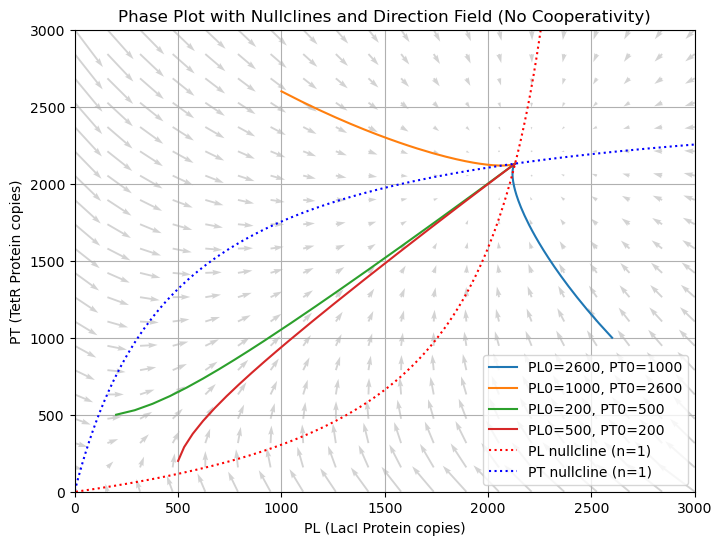

In [8]:
# Part 6: Phase Plot showing Toggle Switch system behaviour with 𝑛𝐿 = 𝑛𝑇 = 1

# System parameters with no cooperativity (nL = nT = 1)
v_poL = v_poT = 0.0866
v_pL = v_pT = 43.3
v_dpL = v_dpT = 0.0165
K_L = K_T = 500
n_L = n_T = 1  # Cooperativity set to 1

# Define the reduced model with n_L and n_T set to 1
def reduced_toggle_switch_no_coop(y, t):
    PL, PT = y
    dPL_dt = v_poL + (v_pL * PT**n_T) / (K_T**n_T + PT**n_T) - v_dpL * PL
    dPT_dt = v_poT + (v_pT * PL**n_L) / (K_L**n_L + PL**n_L) - v_dpT * PT
    return [dPL_dt, dPT_dt]

# Running simulations and generate phase plot with the given initial conditions
plt.figure(figsize=(8, 6))

# Calculating trajectories and plot them
for PL0, PT0 in initial_conditions:
    trajectory = odeint(reduced_toggle_switch_no_coop, [PL0, PT0], t)
    plt.plot(trajectory[:, 0], trajectory[:, 1], label=f'PL0={PL0}, PT0={PT0}')

# Direction field / Vector field
PL_vals = np.linspace(0, 3000, 20)
PT_vals = np.linspace(0, 3000, 20)
PL_mesh, PT_mesh = np.meshgrid(PL_vals, PT_vals)
dPL_mesh, dPT_mesh = reduced_toggle_switch_no_coop([PL_mesh, PT_mesh], t)
plt.quiver(PL_mesh, PT_mesh, dPL_mesh, dPT_mesh, color='lightgray')

# Nullcline for PL when n_L = n_T = 1
PL_nullcline_PL_vals = (v_poL + (v_pL * PL_nullcline_PT_vals**n_T) / 
                        (K_T**n_T + PL_nullcline_PT_vals**n_T)) / v_dpL

# Nullcline for PT when n_L = n_T = 1
PT_nullcline_PT_vals = (v_poT + (v_pT * PT_nullcline_PL_vals**n_L) / 
                        (K_L**n_L + PT_nullcline_PL_vals**n_L)) / v_dpT

# Adding nullclines to the plot
plt.plot(PL_nullcline_PL_vals, PL_nullcline_PT_vals, 'r:', label='PL nullcline (n=1)')
plt.plot(PT_nullcline_PL_vals, PT_nullcline_PT_vals, 'b:', label='PT nullcline (n=1)')

# Final plot adjustments
plt.xlabel('PL (LacI Protein copies)')
plt.ylabel('PT (TetR Protein copies)')
plt.title('Phase Plot with Nullclines and Direction Field (No Cooperativity)')
plt.legend()
plt.xlim([0, 3000])
plt.ylim([0, 3000])
plt.grid(True)
plt.savefig('Phase_plot_with_nullclines_and_direction_field_no_coop.png')


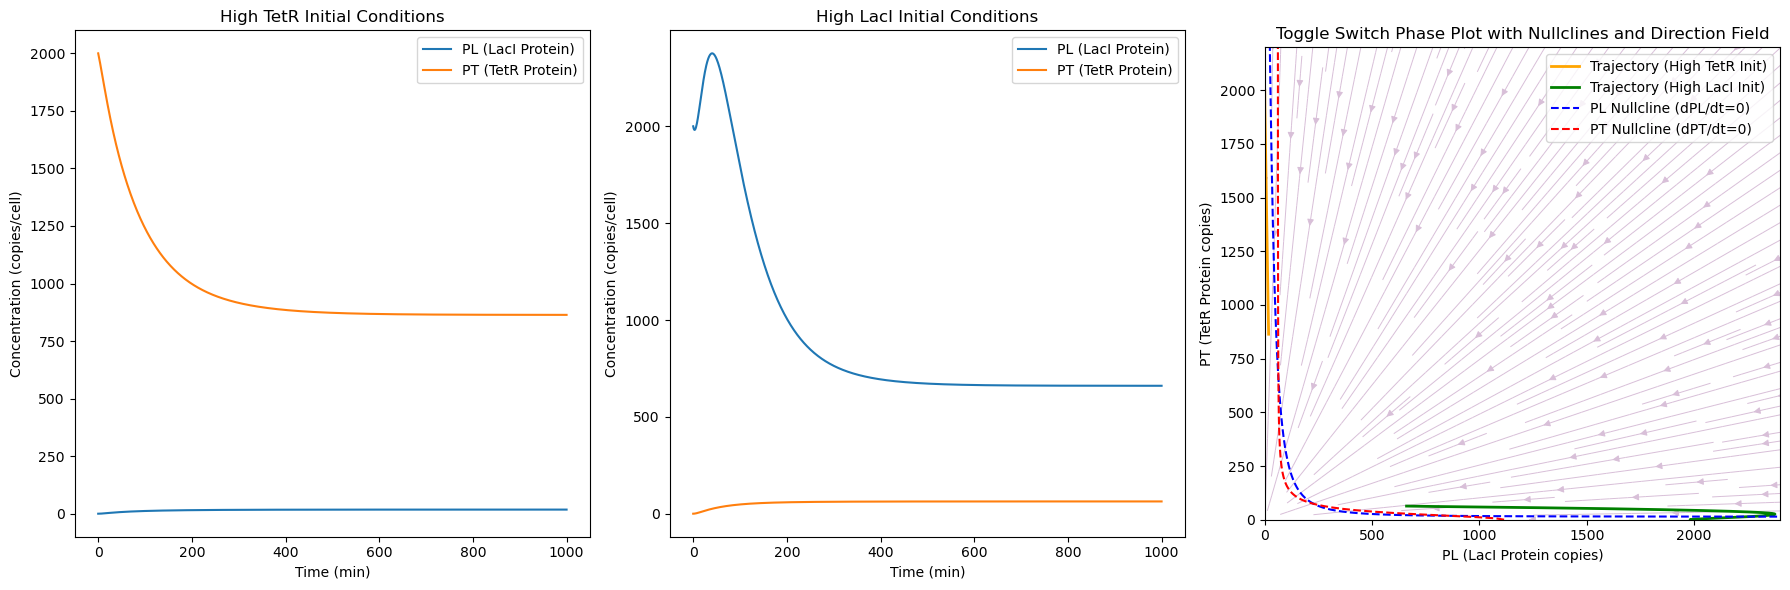

In [9]:
# Task 3

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random

# Part 1: Toggle switch model using the Lugange et al. parameter values. 
# The plots illustrate the bistable behaviour.

# Parameter values from Lugagne et al.
km0L = 0.032
kmL = 8.30
KT = 30
nT = 2
kdmL = 0.1386
kpL = 0.9726
kdpL = 0.0165

km0T = 0.119
kmT = 2.06
KL = 31.94
nL = 2
kdmT = 0.1386
kpT = 1.170
kdpT = 0.0165

# Defining the ODEs for the toggle switch model
def toggle_switch_model(y, t):
    ML, PL, MT, PT = y
    dMLdt = km0L + kmL / (1 + (PT/KT)**nT) - kdmL * ML
    dPLdt = kpL * ML - kdpL * PL
    dMTdt = km0T + kmT / (1 + (PL/KL)**nL) - kdmT * MT
    dPTdt = kpT * MT - kdpT * PT
    return [dMLdt, dPLdt, dMTdt, dPTdt]

# Initial conditions for the two stable states
initial_conditions_high_TetR = [0, 0, 20, 2000] # High TetR, low LacI
initial_conditions_high_LacI = [20, 2000, 0, 0] # High LacI, low TetR

# Time vector
t = np.linspace(0, 1000, 1000) # 1000 minutes

# Integrating ODEs to get the time series data
solution_high_TetR = odeint(toggle_switch_model, initial_conditions_high_TetR, t)
solution_high_LacI = odeint(toggle_switch_model, initial_conditions_high_LacI, t)

# Creating phase plot data
PL_vals = np.linspace(0, 2500, 20)
PT_vals = np.linspace(0, 2500, 20)
PL_mesh, PT_mesh = np.meshgrid(PL_vals, PT_vals)
U, V = np.zeros_like(PL_mesh), np.zeros_like(PT_mesh)

for i in range(PL_mesh.shape[0]):
    for j in range(PL_mesh.shape[1]):
        _, dPLdt, _, dPTdt = toggle_switch_model([0, PL_mesh[i, j], 0, PT_mesh[i, j]], 0)
        U[i, j], V[i, j] = dPLdt, dPTdt

# Nullclines
# Defining a fine grid
pl_vals_fine = np.linspace(0, 2500, 400)
pt_vals_fine = np.linspace(0, 2500, 400)
# For LacI nullcline (dPL/dt = 0), assume MT is constant (since dMTdt = 0 when dPTdt = 0)
pl_nullcline = [kpL/kdpL * (km0L + kmL / (1 + (pt/KT)**nT)) / kdmL for pt in pt_vals_fine]

# For TetR nullcline (dPT/dt = 0), assume ML is constant (since dMLdt = 0 when dPLdt = 0)
pt_nullcline = [kpT/kdpT * (km0T + kmT / (1 + (pl/KL)**nL)) / kdmT for pl in pl_vals_fine]

# Generate plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot PL and PT over time for high TetR initial conditions
axes[0].plot(t, solution_high_TetR[:, 1], label='PL (LacI Protein)')
axes[0].plot(t, solution_high_TetR[:, 3], label='PT (TetR Protein)')
axes[0].set_title('High TetR Initial Conditions')
axes[0].set_xlabel('Time (min)')
axes[0].set_ylabel('Concentration (copies/cell)')
axes[0].legend()

# Plot PL and PT over time for high LacI initial conditions
axes[1].plot(t, solution_high_LacI[:, 1], label='PL (LacI Protein)')
axes[1].plot(t, solution_high_LacI[:, 3], label='PT (TetR Protein)')
axes[1].set_title('High LacI Initial Conditions')
axes[1].set_xlabel('Time (min)')
axes[1].set_ylabel('Concentration (copies/cell)')
axes[1].legend()

# 3rd Plot

# Phase plot with direction field.
axes[2].streamplot(PL_mesh, PT_mesh, U, V, density=2, color='thistle', linewidth=0.7)
axes[2].plot(solution_high_TetR[:, 1], solution_high_TetR[:, 3], label='Trajectory (High TetR Init)', color='orange', linewidth=2)
axes[2].plot(solution_high_LacI[:, 1], solution_high_LacI[:, 3], label='Trajectory (High LacI Init)', color='green', linewidth=2)

# Plot limits
axes[2].set_xlim([0, 2400])
axes[2].set_ylim([0, 2200])

# Plot nullclines
axes[2].plot(pl_vals_fine, pl_nullcline, 'b--', label='PL Nullcline (dPL/dt=0)')
axes[2].plot(pt_nullcline, pt_vals_fine, 'r--', label='PT Nullcline (dPT/dt=0)')

# Adjust to a square aspect ratio
axes[2].set_aspect('equal')

# Title and legend
plt.title('Toggle Switch Phase Plot with Nullclines and Direction Field')
plt.legend(loc='best')

# Axis labels
plt.xlabel('PL (LacI Protein copies)')
plt.ylabel('PT (TetR Protein copies)')

# Display
plt.tight_layout()
plt.savefig('Experimental_parameter_behaviour_plots.png')



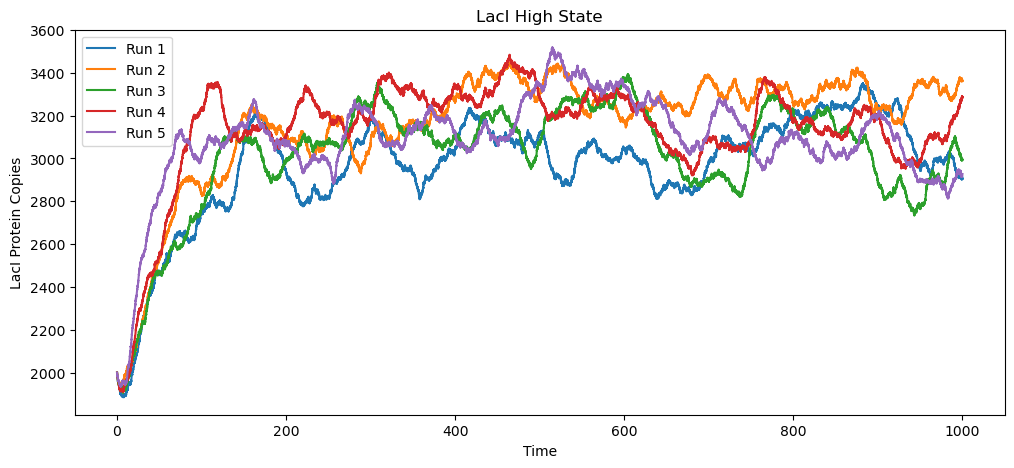

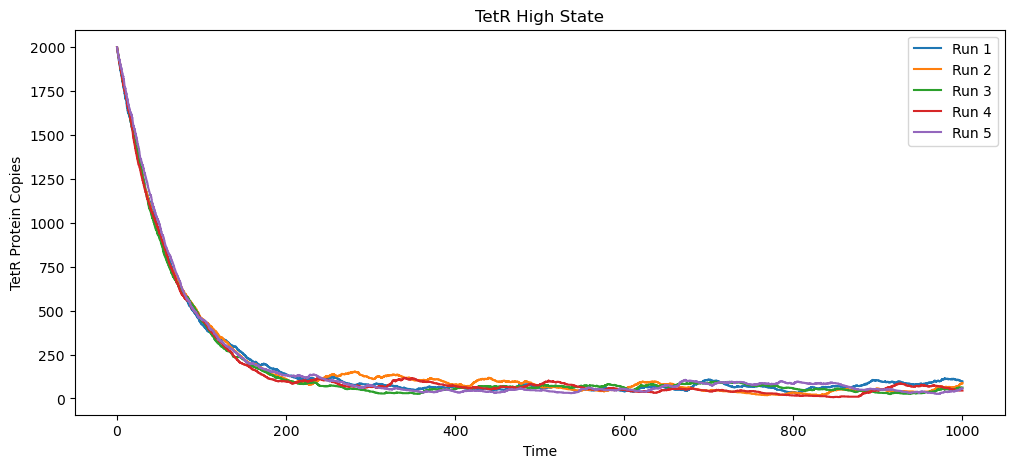

In [10]:
# Part 2: Stochastic version of the Toggle Switch system.

# Gillespie algorithm for the Toggle Switch model
def gillespie_toggle_switch(initial_state, parameters, max_time):
    # Unpack parameters
    km0L, kmL, KR, nR, kdmL, kpL, kdpL, km0T, kmT, KL, nL, kdmT, kpT, kdpT = parameters
    
    # State vector [ML, PL, MT, PT]
    state = np.array(initial_state, dtype=float)
    
    # Time starts at 0
    t = 0
    
    # Arrays to store time and state history
    t_history = [t]
    state_history = [state.copy()]
    
    # Reaction propensities
    def propensities(state):
        ML, PL, MT, PT = state
        return np.array([
            km0L + kmL / (1 + (PT/KR)**nR),  # LacI mRNA production
            kdmL * ML,                      # LacI mRNA degradation
            kpL * ML,                       # LacI protein production
            kdpL * PL,                      # LacI protein degradation
            km0T + kmT / (1 + (PL/KL)**nL), # TetR mRNA production
            kdmT * MT,                      # TetR mRNA degradation
            kpT * MT,                       # TetR protein production
            kdpT * PT                       # TetR protein degradation
        ])
    
    # Run simulation
    while t < max_time:
        props = propensities(state)
        total_propensity = np.sum(props)
        
        if total_propensity <= 0:
            break
        
        # Time until next reaction
        t += random.expovariate(total_propensity)
        
        # Choose which reaction will occur
        reaction = np.searchsorted(np.cumsum(props), random.uniform(0, total_propensity))
        
        # Update state
        if reaction == 0:
            state[0] += 1  # LacI mRNA production
        elif reaction == 1:
            state[0] -= 1  # LacI mRNA degradation
        elif reaction == 2:
            state[1] += 1  # LacI protein production
        elif reaction == 3:
            state[1] -= 1  # LacI protein degradation
        elif reaction == 4:
            state[2] += 1  # TetR mRNA production
        elif reaction == 5:
            state[2] -= 1  # TetR mRNA degradation
        elif reaction == 6:
            state[3] += 1  # TetR protein production
        elif reaction == 7:
            state[3] -= 1  # TetR protein degradation
        
        # Store history
        t_history.append(t)
        state_history.append(state.copy())
    
    return np.array(t_history), np.array(state_history)

# Parameters and initial states
parameters = [km0L, kmL, KR, nR, kdmL, kpL, kdpL, km0T, kmT, KL, nL, kdmT, kpT, kdpT]
initial_state_high_LacI = [0, 2000, 0, 20]
initial_state_high_TetR = [0, 20, 0, 2000]

# Number of runs to simulate
num_runs = 5

# Simulation for high LacI state
plt.figure(figsize=(12, 5))
for i in range(num_runs):
    t_history, state_history = gillespie_toggle_switch(initial_state_high_LacI, parameters, 1000)
    plt.plot(t_history, state_history[:, 1], label=f'Run {i+1}')
plt.title('LacI High State')
plt.xlabel('Time')
plt.ylabel('LacI Protein Copies')
plt.legend()
plt.savefig('LacI_High_State_simul.png')

# Simulation for high TetR state
plt.figure(figsize=(12, 5))
for i in range(num_runs):
    t_history, state_history = gillespie_toggle_switch(initial_state_high_TetR, parameters, 1000)
    plt.plot(t_history, state_history[:, 3], label=f'Run {i+1}')
plt.title('TetR High State')
plt.xlabel('Time')
plt.ylabel('TetR Protein Copies')
plt.legend()
plt.savefig('TetR_High_State_simul.png')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


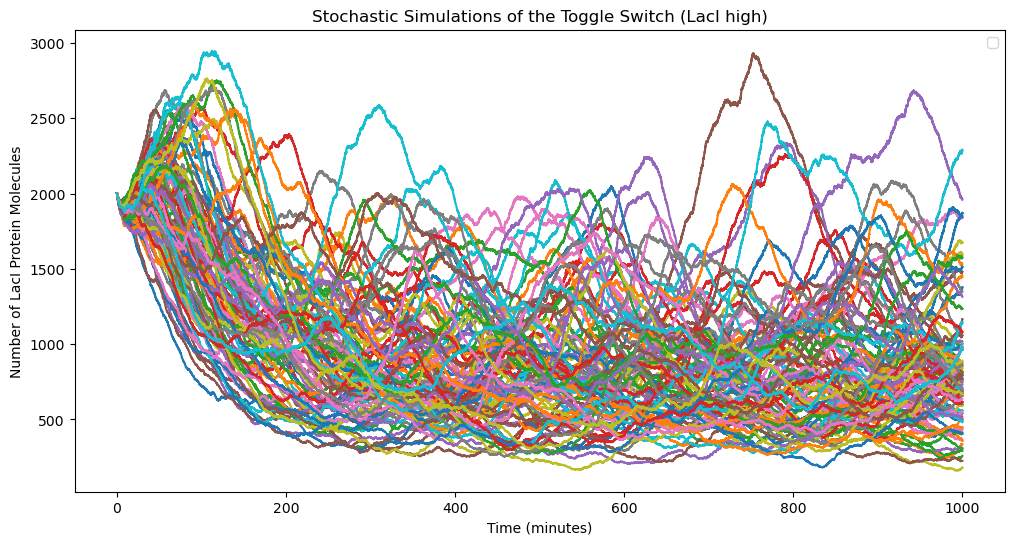

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


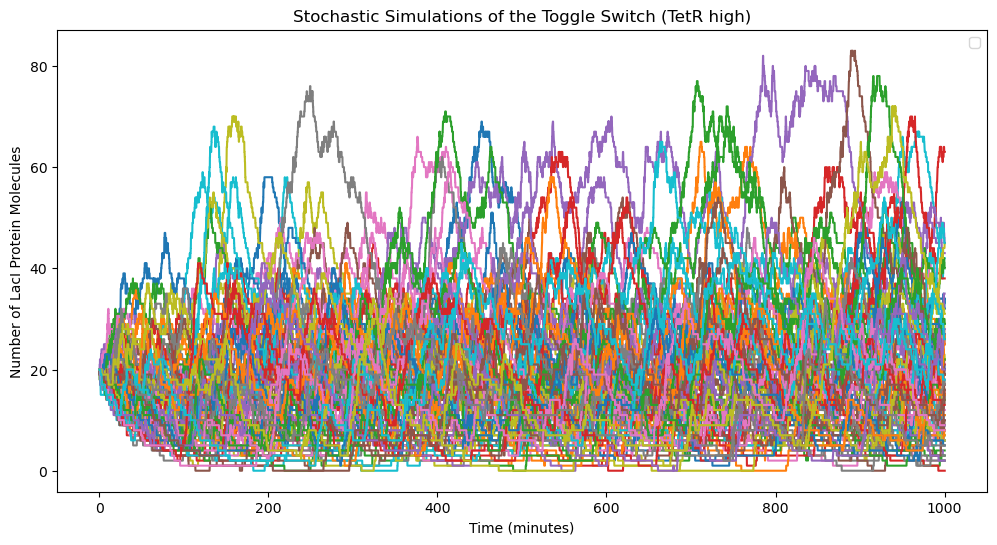

In [11]:
# Part 3: Stochastic simulations starting in the 
# i) LacI high state
# ii) TetR high state

# Gillespie algorithm for the Toggle Switch model
def gillespie_toggle_switch(initial_state, parameters, max_time):
    # Unpack parameters
    km0L, kmL, KR, nR, kdmL, kpL, kdpL, km0T, kmT, KL, nL, kdmT, kpT, kdpT = parameters
    
    # State vector [ML, PL, MT, PT]
    state = np.array(initial_state, dtype=float)
    
    # Time starts at 0
    t = 0
    
    # Arrays to store time and state history
    t_history = [t]
    state_history = [state.copy()]
    
    # Reaction propensities
    def propensities(state):
        ML, PL, MT, PT = state
        return np.array([
            km0L + kmL / (1 + (PT/KR)**nR),  # LacI mRNA production
            kdmL * ML,                      # LacI mRNA degradation
            kpL * ML,                       # LacI protein production
            kdpL * PL,                      # LacI protein degradation
            km0T + kmT / (1 + (PL/KL)**nL), # TetR mRNA production
            kdmT * MT,                      # TetR mRNA degradation
            kpT * MT,                       # TetR protein production
            kdpT * PT                       # TetR protein degradation
        ])
    
    # Run simulation
    while t < max_time:
        props = propensities(state)
        total_propensity = np.sum(props)
        
        if total_propensity <= 0:
            break
        
        # Time until next reaction
        t += random.expovariate(total_propensity)
        
        # Choose which reaction will occur
        reaction = np.searchsorted(np.cumsum(props), random.uniform(0, total_propensity))
        
        # Update state
        if reaction == 0:
            state[0] += 1  # LacI mRNA production
        elif reaction == 1:
            state[0] -= 1  # LacI mRNA degradation
        elif reaction == 2:
            state[1] += 1  # LacI protein production
        elif reaction == 3:
            state[1] -= 1  # LacI protein degradation
        elif reaction == 4:
            state[2] += 1  # TetR mRNA production
        elif reaction == 5:
            state[2] -= 1  # TetR mRNA degradation
        elif reaction == 6:
            state[3] += 1  # TetR protein production
        elif reaction == 7:
            state[3] -= 1  # TetR protein degradation
        
        # Store history
        t_history.append(t)
        state_history.append(state.copy())
    
    return np.array(t_history), np.array(state_history)

# Parameters from the table
parameters = [
    0.032,  # km0L
    8.30,   # kmL
    30,     # KR
    2,      # nR
    0.1386, # kdmL
    0.9726, # kpL
    0.0165, # kdpL
    0.119,  # km0T
    2.06,   # kmT
    31.94,  # KL
    2,      # nL
    0.1386, # kdmT
    1.170,  # kpT
    0.0165  # kdpT
]

# Define the number of runs for stochastic simulation.
# Change this to run more simulations (e.g., 100 for a full stochastic analysis).
num_runs = 100

# Initial states for the two different scenarios: LacI high and TetR high
initial_state_high_LacI = [0, 2000, 0, 20]  # LacI high state
initial_state_high_TetR = [0, 20, 0, 2000]  # TetR high state

# Function to run the simulations and plot the results
def simulate_and_plot(initial_state, parameters, num_runs, max_time, title):
    plt.figure(figsize=(12, 6))
    
    # Simulate and plot the results
    for i in range(num_runs):
        t_history, state_history = gillespie_toggle_switch(initial_state, parameters, max_time)
        plt.plot(t_history, state_history[:, 1])

    plt.title(title)
    plt.xlabel('Time (minutes)')
    plt.ylabel('Number of LacI Protein Molecules')
    plt.legend()
    plt.show()

# Using this function to simulate both scenarios
# LacI high initial state
simulate_and_plot(initial_state_high_LacI, parameters, num_runs, 1000, 'Stochastic Simulations of the Toggle Switch (LacI high)')

# TetR high initial state
simulate_and_plot(initial_state_high_TetR, parameters, num_runs, 1000, 'Stochastic Simulations of the Toggle Switch (TetR high)')

# This is just to show our simulation is working
# Will probably be omitted for our final report.

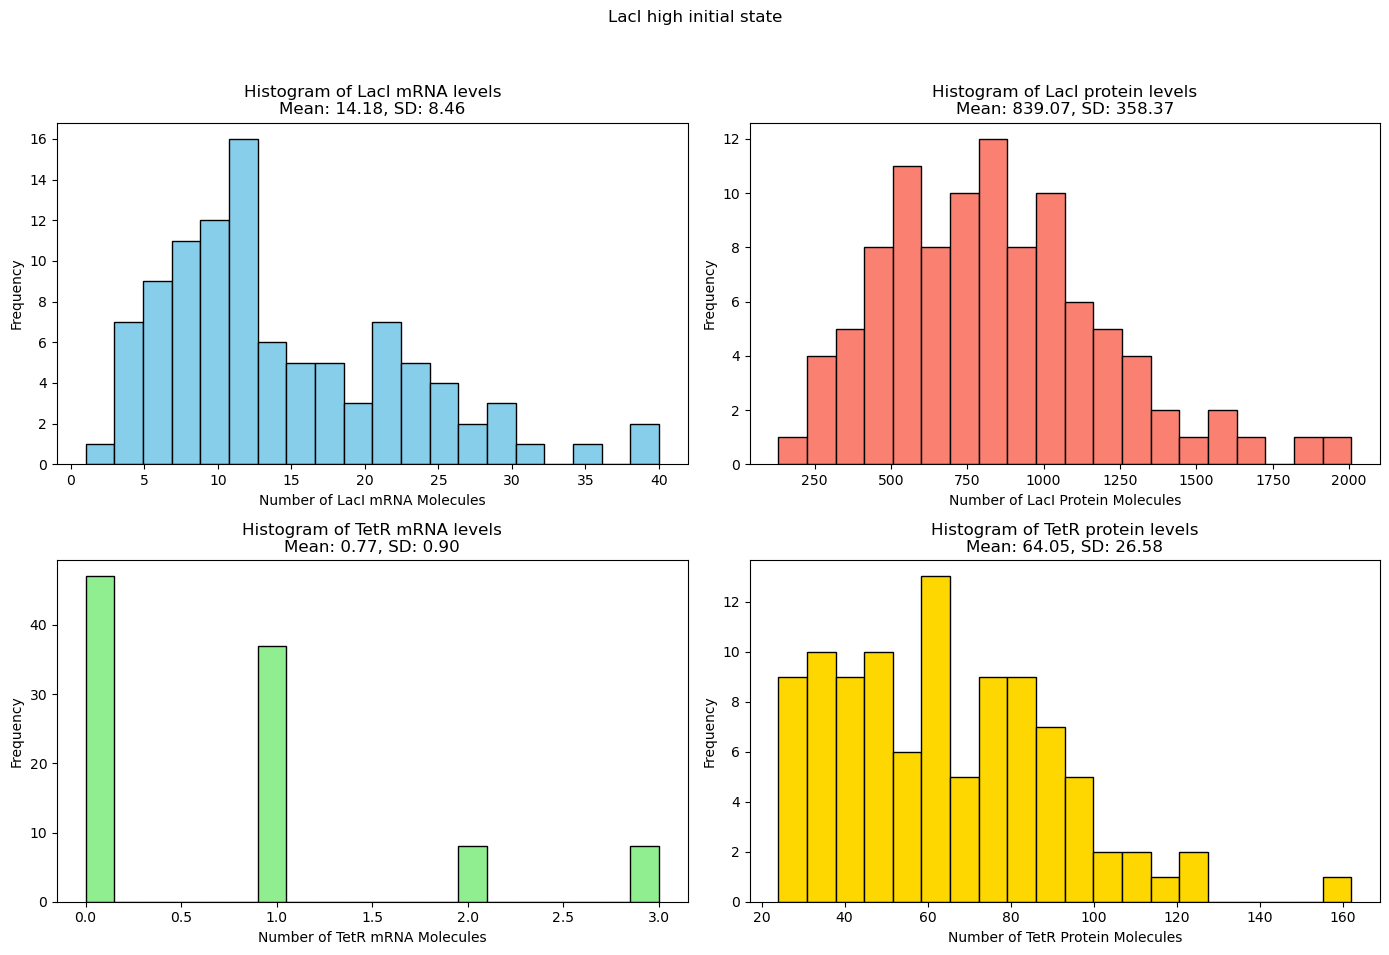

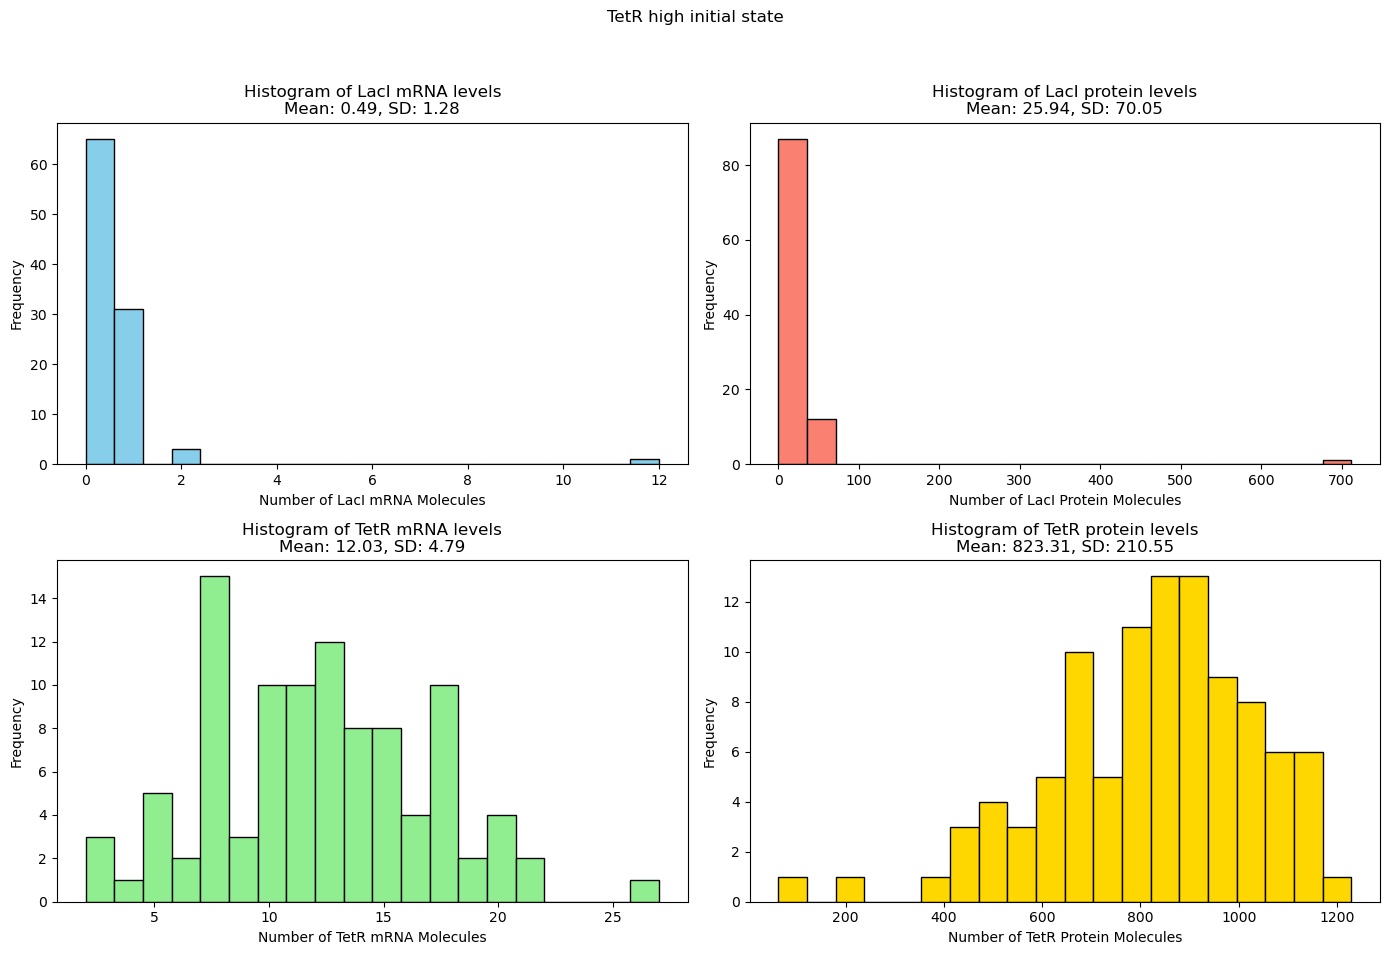

In [12]:
# Part 4 (final): Histograms with summary statistics 
# of mRNA protein levels at the end of the simulation

def simulate_and_collect_final_states(initial_state, parameters, num_runs, max_time):
    final_states = []  # This will store the final state for each run
    
    # Run simulations
    for _ in range(num_runs):
        t_history, state_history = gillespie_toggle_switch(initial_state, parameters, max_time)
        final_states.append(state_history[-1])
    
    return np.array(final_states)

# Function to plot histograms and display summary statistics
def plot_histograms_and_stats(final_states, title, filename):
    # Calculate summary statistics
    means = np.mean(final_states, axis=0)
    std_devs = np.std(final_states, axis=0)
    
    # Plot histograms and note the summary statistics for mRNA and protein levels
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # LacI mRNA
    axs[0, 0].hist(final_states[:, 0], bins=20, color='skyblue', edgecolor='black')
    axs[0, 0].set_title(f'Histogram of LacI mRNA levels\nMean: {means[0]:.2f}, SD: {std_devs[0]:.2f}')
    axs[0, 0].set_xlabel('Number of LacI mRNA Molecules')
    axs[0, 0].set_ylabel('Frequency')

    # LacI protein
    axs[0, 1].hist(final_states[:, 1], bins=20, color='salmon', edgecolor='black')
    axs[0, 1].set_title(f'Histogram of LacI protein levels\nMean: {means[1]:.2f}, SD: {std_devs[1]:.2f}')
    axs[0, 1].set_xlabel('Number of LacI Protein Molecules')
    axs[0, 1].set_ylabel('Frequency')

    # TetR mRNA
    axs[1, 0].hist(final_states[:, 2], bins=20, color='lightgreen', edgecolor='black')
    axs[1, 0].set_title(f'Histogram of TetR mRNA levels\nMean: {means[2]:.2f}, SD: {std_devs[2]:.2f}')
    axs[1, 0].set_xlabel('Number of TetR mRNA Molecules')
    axs[1, 0].set_ylabel('Frequency')

    # TetR protein
    axs[1, 1].hist(final_states[:, 3], bins=20, color='gold', edgecolor='black')
    axs[1, 1].set_title(f'Histogram of TetR protein levels\nMean: {means[3]:.2f}, SD: {std_devs[3]:.2f}')
    axs[1, 1].set_xlabel('Number of TetR Protein Molecules')
    axs[1, 1].set_ylabel('Frequency')

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(filename)
    plt.show()

# These functions simulate and plot for LacI high initial state
final_states_high_LacI = simulate_and_collect_final_states(initial_state_high_LacI, parameters, num_runs, 1000)
plot_histograms_and_stats(final_states_high_LacI, 'LacI high initial state', 'LacI_high_hist')

# And for TetR high initial state
final_states_high_TetR = simulate_and_collect_final_states(initial_state_high_TetR, parameters, num_runs, 1000)
plot_histograms_and_stats(final_states_high_TetR, 'TetR high initial state', 'TetR_high_hist')
